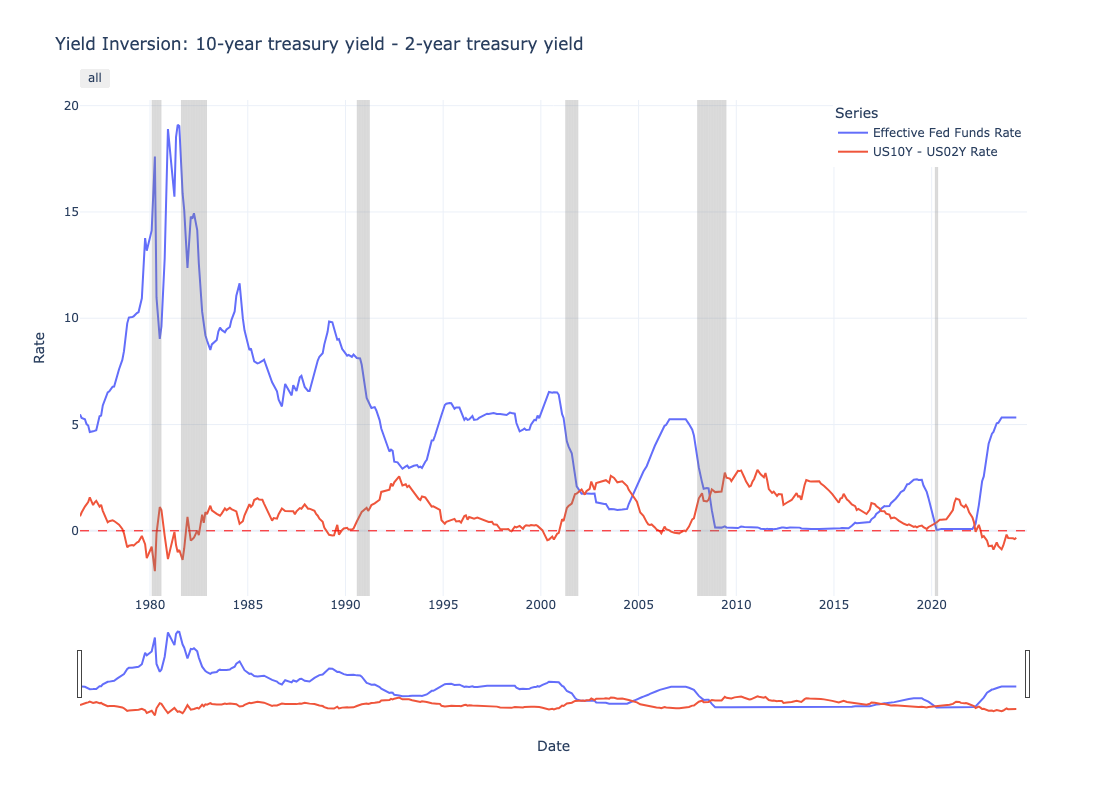

In [10]:
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sys
import os
from datetime import datetime
from fredapi import Fred

# Add the src directory to sys.path
src_path = os.path.expanduser('~/Desktop/GitHub/SPX_Analysis/src')
sys.path.append(src_path)

import importlib
import fetcher
importlib.reload(fetcher)
from fetcher import SeriesFetcher

def constructDF():
    # get the data DGS2 and DGS10
    DGS2 = SeriesFetcher('DGS2')
    DGS10 = SeriesFetcher('DGS10')
    fedfunds = SeriesFetcher('FEDFUNDS')

    data = pd.DataFrame({
        'US02Y': DGS2.get_series_data(),
        'US10Y': DGS10.get_series_data(),
        'FEDFUNDS': fedfunds.get_series_data()
    })

    # Drop rows with missing values & Convert index to datetime
    data.dropna(inplace=True)
    data.index = pd.to_datetime(data.index)
    
    # Create the Real10YrInflInterest series
    data['US10Y-US02Y'] = data['US10Y'] - data['US02Y']
    
    return data

def shade_recession_months(fig, usrec_series):
    # grey out timeframes with NBER recessions
    for date, value in usrec_series.items():
        date = pd.to_datetime(date)
        if value == 1:
            fig.add_vrect(
                x0=date, x1=date + pd.DateOffset(months=1),
                fillcolor="grey", opacity=0.3, line_width=0
            )

if __name__ == "__main__":
    today = pd.Timestamp.now().date()
    offset_days = 200

    # Construct the RealFlation DataFrame & establish min/max indexed date
    YieldInversion = constructDF()
    data_start_date = RealFlation.index.min()
    data_end_date = RealFlation.index.max()
    
    # Create Plotly figure & Add traces for each series
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['FEDFUNDS'], mode='lines', name='Effective Fed Funds Rate'))
    fig.add_trace(go.Scatter(x=RealFlation.index, y=RealFlation['US10Y-US02Y'], mode='lines', name='US10Y - US02Y Rate'))

    fig.add_hline(y=0, line=dict(color='red', width=1, dash='dash'))
    
    # # Fetch the current 10-year Treasury yield (DGS10) and display it as a reference
    # dgs10 = SeriesFetcher('DGS10')
    # current_dgs10 = dgs10.get_latest_value()
    # if current_dgs10 is not None:
    #     fig.add_hline(y=current_dgs10, line=dict(color='red', width=1, dash='dash'), annotation_text=f'US10Y: {current_dgs10}', annotation_position='bottom right')
    # else:
    #     print("Failed to fetch the current 10-year Treasury yield.")

    # Shade the recession periods based on the "USREC" series
    USREC = SeriesFetcher('USREC')
    usrec_series = USREC.get_series_data(data_start_date)
    shade_recession_months(fig, usrec_series)
    
    # Update layout with correct x-axis range and range slider range
    fig.update_layout(
        title='Yield Inversion: 10-year treasury yield - 2-year treasury yield',
        xaxis_title='Date',
        yaxis_title='Rate',
        legend_title='Series',
        legend=dict(
            x=1,
            y=1,
            xanchor='right',
            yanchor='top',
        ),
        template='plotly_white',
        width=1100,  # Set the width of the chart
        height=800,  # Set the height of the chart
        xaxis=dict(
            rangeselector=dict(buttons=list([
                dict(step="all")
            ])),
            rangeslider=dict(
                visible=True,
                autorange=True,
                yaxis=dict(
                        # rangemode="match",  # Ensures the y-axis matches the main plot
                        # autorange=True,     # Automatically adjust y-axis range
                        # fixedrange=True    # Allow y-axis range to be adjusted
                    )
            ), 
            type="date",
            range=[data_start_date, data_end_date + pd.DateOffset(days=offset_days)]
        ),
        yaxis=dict(
            autorange=True,  # Enable dynamic y-axis scaling
            fixedrange=False
        )
    )
    
    # Show the figure
    fig.show()


In [11]:
YieldInversion.tail(5)

,US02Y,US10Y,FEDFUNDS,US10Y-US02Y
2023-12-01,4.56,4.22,5.33,-0.34
2024-02-01,4.20,3.87,5.33,-0.33
2024-03-01,4.54,4.19,5.33,-0.35
2024-04-01,4.72,4.33,5.33,-0.39
2024-05-01,4.96,4.63,5.33,-0.33
